# Question 1
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

In [16]:
def log_joint_posterior(data, theta, var, nu, theta0, var0):
    """
    Computes the unnormalized joint posterior:
    p(theta, var, nu | x) ∝ p(x | theta, var, nu) * p(theta) * p(var) * p(nu)
    
    Args:
      data  : observed data (array)
      theta : proposed mean (scalar)
      var   : proposed variance (scalar)
      nu    : proposed degrees of freedom (scalar)
      theta0: prior mean for theta (scalar)
      var0  : prior variance for theta (scalar)
    
    Returns:
      posterior_value: unnormalized posterior probability (scalar)
    """
    n = len(data)
    if (var <= 0):
        return -np.inf  # Return -inf for log probabilities to avoid numerical issues
    else:
        # Log Likelihood (t-distribution with nu degrees of freedom)   
        log_likelihood = np.sum(stats.t.logpdf(data, nu, theta, np.sqrt(var)))

        # Log Prior for theta (normal with mean theta0 and variance var0)
        log_prior_theta = stats.norm.logpdf(theta, loc=theta0, scale=np.sqrt(var0))

        # Prior for var (Half-normal with scale var0**0.5)
        log_prior_var = stats.halfnorm.logpdf(var, loc=0, scale=np.sqrt(var0))
        
        # Prior for nu (discrete uniform from 1 to 100, using log of pmf)
        log_prior_nu = np.log(stats.randint.pmf(nu, 1, 101))  
    
        # Compute posterior (sum of log probabilities)
        return log_likelihood + log_prior_theta + log_prior_var + log_prior_nu

def metropolis_within_gibbs(data, theta0, var0, prop_sd_theta, prop_sd_var, burn_in, n_iter=5000):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, variance=var)
    
    Args:
      data     : 1D array of observed data
      theta0   : prior mean for theta
      var0     : prior variance for theta
      prop_sd_theta : proposal standard deviation for theta
      prop_sd_var   : proposal standard deviation for var
      n_iter   : number of iterations
      burn_in  : number of samples to discard
    
    Returns:
      (theta_samples, var_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    
    # Storage
    theta_samples = np.zeros(n_iter)
    var_samples = np.zeros(n_iter)
    nu_samples = np.zeros(n_iter)

    # Initialize parameters
    var_current = stats.halfnorm.rvs(scale=np.sqrt(var0))  
    theta_current = np.random.normal(loc=theta0, scale=np.sqrt(var0))  
    nu_current = np.random.randint(1, 101)  

    # Track acceptance rates for tuning
    theta_acceptances = 0
    var_acceptances = 0
    nu_acceptances = 0

    for t in range(n_iter):
        # Step 1: Metropolis update for theta
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)  # Scalar

        log_p_current_theta = log_joint_posterior(data, theta_current, var_current, nu_current, theta0, var0)
        log_p_proposed_theta = log_joint_posterior(data, theta_proposed, var_current, nu_current, theta0, var0)
        
        log_acceptance_ratio_theta = log_p_proposed_theta - log_p_current_theta
        if np.random.rand() < min(1, np.exp(log_acceptance_ratio_theta)):
            theta_current = theta_proposed  # Accept
            theta_acceptances += 1

        # Step 2: Metropolis update for var
        var_proposed = np.exp(np.random.normal(np.log(var_current), prop_sd_var))  # Log-normal proposal for positive var

        log_p_current_var = log_joint_posterior(data, theta_current, var_current, nu_current, theta0, var0)
        log_p_proposed_var = log_joint_posterior(data, theta_current, var_proposed, nu_current, theta0, var0)
        
        log_acceptance_ratio_var = log_p_proposed_var - log_p_current_var + \
            stats.halfnorm.logpdf(var_current, loc=0, scale=np.sqrt(var0)) - \
            stats.halfnorm.logpdf(var_proposed, loc=0, scale=np.sqrt(var0))
        
        if np.random.rand() < min(1, np.exp(log_acceptance_ratio_var)):
            var_current = var_proposed  # Accept
            var_acceptances += 1
        
        # Step 3: Metropolis update for nu
        nu_proposed = np.random.randint(1, 101)  # Propose new nu from discrete uniform

        log_p_current_nu = log_joint_posterior(data, theta_current, var_current, nu_current, theta0, var0)
        log_p_proposed_nu = log_joint_posterior(data, theta_current, var_current, nu_proposed, theta0, var0)
        
        log_acceptance_ratio_nu = log_p_proposed_nu - log_p_current_nu
        if np.random.rand() < min(1, np.exp(log_acceptance_ratio_nu)):
            nu_current = nu_proposed  # Accept
            nu_acceptances += 1
        
        # Store samples
        theta_samples[t] = theta_current
        var_samples[t] = var_current
        nu_samples[t] = nu_current

    # Calculate acceptance rates
    print(f"Theta acceptance rate: {theta_acceptances / n_iter * 100:.2f}%")
    print(f"Variance acceptance rate: {var_acceptances / n_iter * 100:.2f}%")
    print(f"Nu acceptance rate: {nu_acceptances / n_iter * 100:.2f}%")

    # Discard burn-in
    return theta_samples[burn_in:], var_samples[burn_in:]

In [21]:
np.random.seed(1)

# Generate synthetic data from Normal(mean = 50, var = 9)
true_theta = 50
true_var = 9
data = np.random.normal(true_theta, np.sqrt(true_var), size=100)

# Set prior hyperparameters
theta0 = 0  # Uninformative prior mean
var0 = 100    # Uninformative prior variance
prop_sd_theta = 0.5  
prop_sd_var = 0.5    


# Run the sampler
theta_samples, var_samples = metropolis_within_gibbs(
    data, theta0, var0, prop_sd_theta, prop_sd_var, burn_in = 400
)

/tmp/ipykernel_52/334618609.py:91: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < min(1, np.exp(log_acceptance_ratio_var)):
/tmp/ipykernel_52/334618609.py:102: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < min(1, np.exp(log_acceptance_ratio_nu)):


Theta acceptance rate: 52.68%
Variance acceptance rate: 33.92%
Nu acceptance rate: 83.06%


In [25]:
print("Posterior mean of theta:", np.mean(theta_samples))
print("Mean of data:", np.mean(data))
print("Posterior mean of var  :", np.mean(var_samples))
print("Variance of data:", np.std(data)**2)

Posterior mean of theta: 50.142539475226194
Mean of data: 50.18174855622709
Posterior mean of var  : 6.933661995409054
Variance of data: 7.051513705962


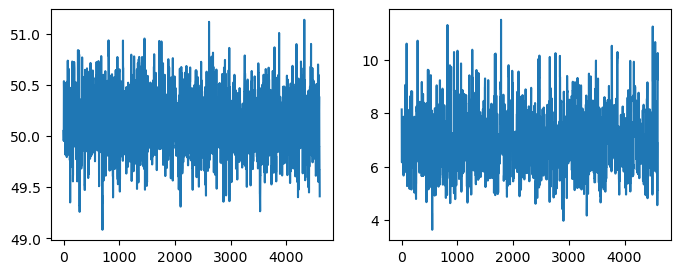

In [23]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(theta_samples)
ax[1].plot(var_samples)

In [26]:
np.quantile(theta_samples, [0.025, 0.975])

array([49.56788546, 50.6773733 ])

In [28]:
np.quantile(var_samples, [0.025, 0.975])

array([4.98301738, 9.2641676 ])

Both our credible intervals contain the values assigned to their respective parameters at the beginning of the simulation.

# Question 2
---

In [3]:
import pymc as pm
import arviz as az

In [4]:
np.random.seed(2)

# True parameters for data generation
true_theta = 50
true_var = 9

# Sample sizes to explore
sample_sizes = [50, 100, 500, 1000, 5000, 10000]

# Store results for comparison
results = {}

In [5]:
# Loop over different sample sizes
for n in sample_sizes:
    # Generate synthetic data from Normal(mean = 50, var = 9)
    data = np.random.normal(true_theta, np.sqrt(true_var), size=n)

    # Define the model with specified priors
    with pm.Model() as model:
        # Priors
        theta = pm.Normal("theta", mu=0, sigma=np.sqrt(100))  # Normal prior for theta, mean=0, var=100
        var = pm.HalfNormal("var", sigma=np.sqrt(100))  # Half-normal prior for variance, scale=sqrt(100)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)  # Discrete uniform prior for nu (1 to 100)

        # Likelihood (t-distribution)
        sigma = pm.Deterministic("sigma", pm.math.sqrt(var))  # Standard deviation
        obs = pm.StudentT("obs", nu=nu, mu=theta, sigma=sigma, observed=data)

        # Sample using NUTS
        idata = pm.sample(chains=4, tune=2000, draws=10000, return_inferencedata=True)

        # Store trace in results
        results[f"n={n}"] = idata

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, var]
>Metropolis: [nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, var]
>Metropolis: [nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, var]
>Metropolis: [nu]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, var]
>Metropolis: [nu]


/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, var]
>Metropolis: [nu]


/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, var]
>Metropolis: [nu]


/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/opt/conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 21 seconds.



Results for sample size n = 50:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  49.456   0.452  48.601   50.298      0.002    0.002   38348.0   
var     9.709   2.106   5.991   13.724      0.014    0.010   20780.0   
nu     51.753  27.692   9.000   99.000      0.322    0.228    6979.0   

       ess_tail  r_hat  
theta   27022.0    1.0  
var     15487.0    1.0  
nu       5778.0    1.0  


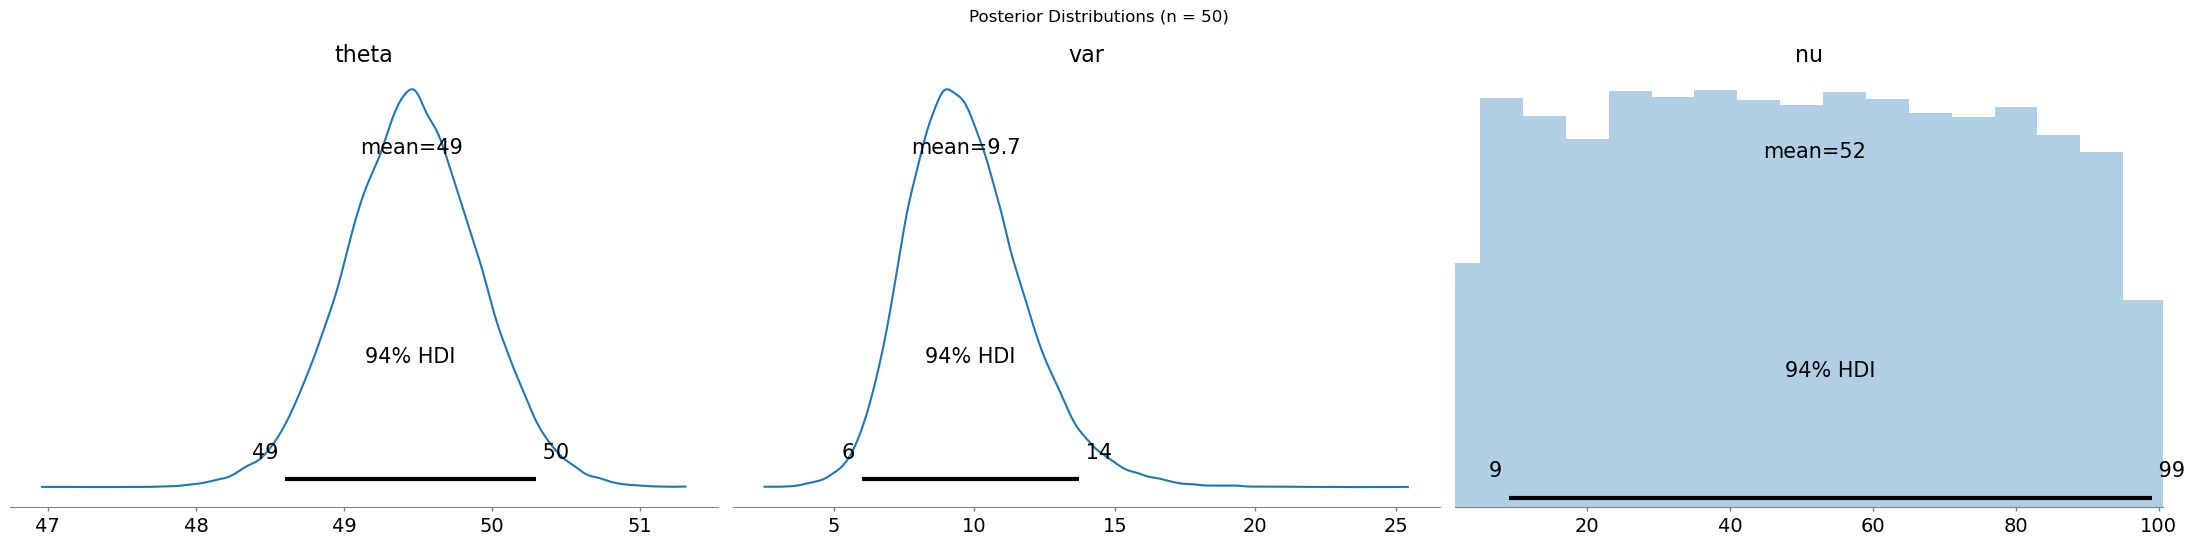

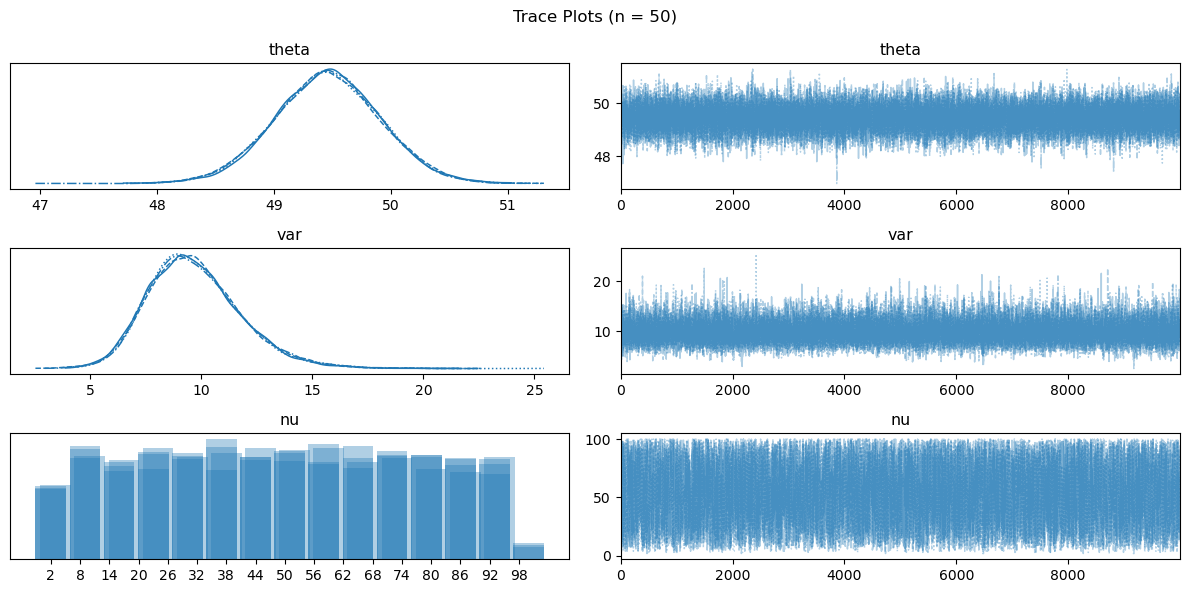


Results for sample size n = 100:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  49.915   0.332  49.277   50.528      0.002    0.001   33769.0   
var    10.427   1.617   7.393   13.439      0.012    0.008   18371.0   
nu     52.108  27.162   8.000   96.000      0.344    0.243    5966.0   

       ess_tail  r_hat  
theta   27545.0    1.0  
var     15507.0    1.0  
nu       5811.0    1.0  


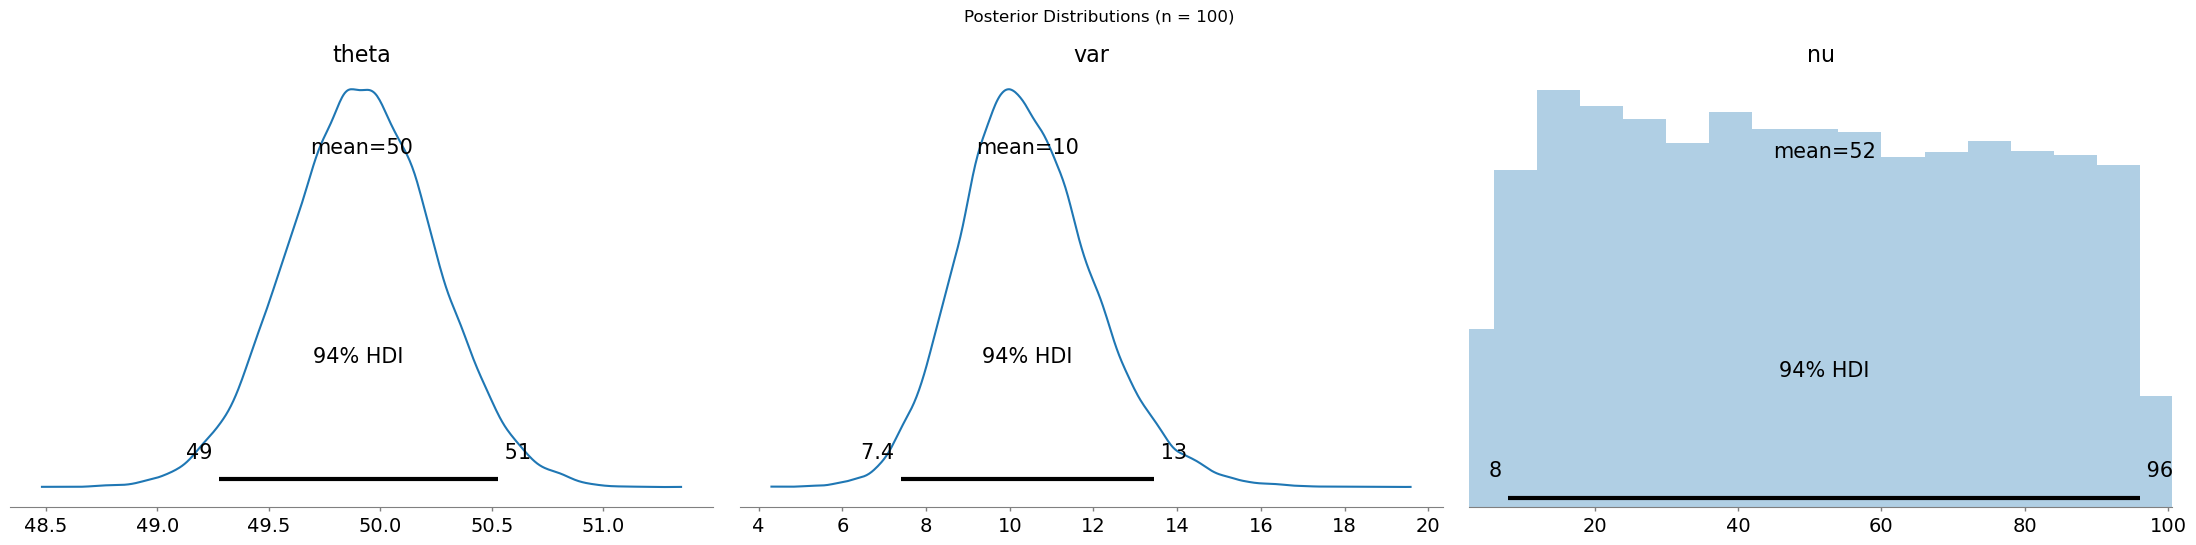

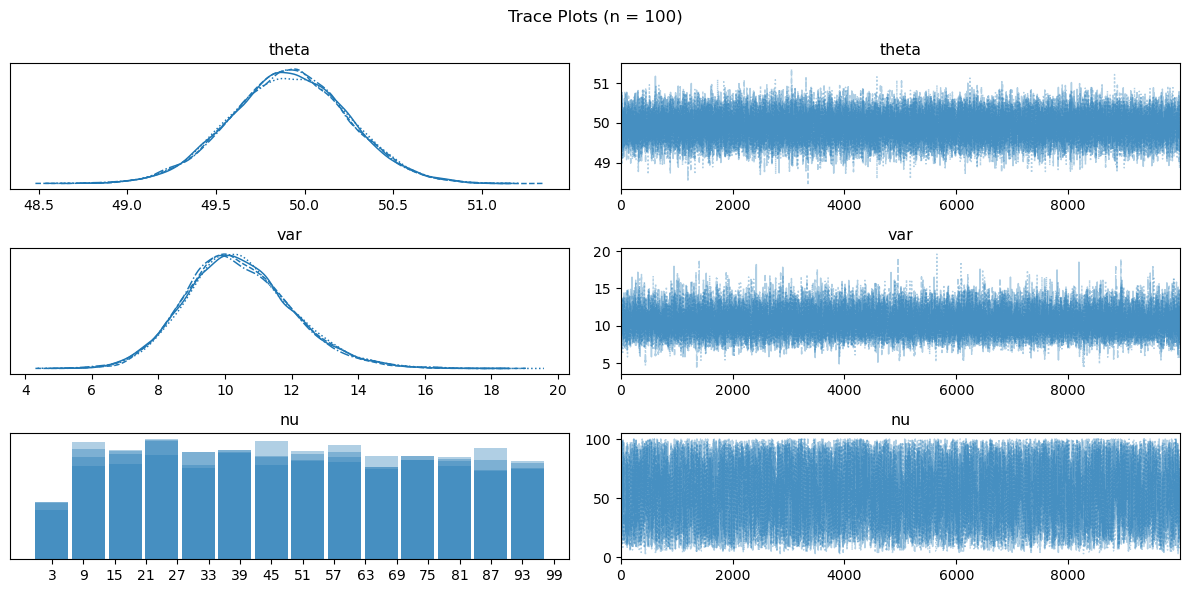


Results for sample size n = 500:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  49.853   0.136  49.596   50.111      0.001    0.000   39207.0   
var     8.876   0.657   7.653   10.117      0.006    0.004   13556.0   
nu     53.585  25.480  14.000   97.000      0.328    0.232    5629.0   

       ess_tail  r_hat  
theta   28110.0    1.0  
var     13242.0    1.0  
nu       5208.0    1.0  


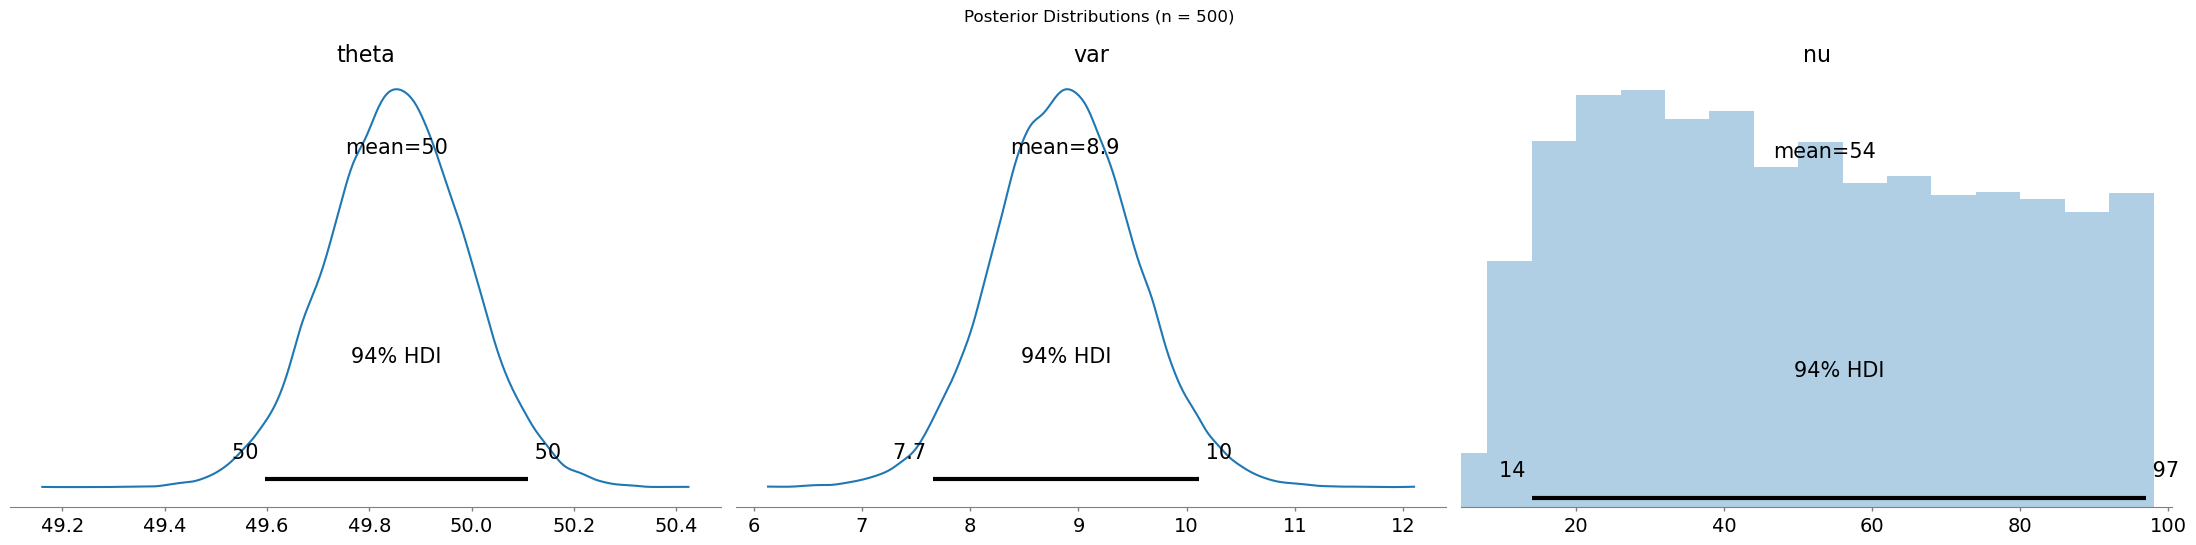

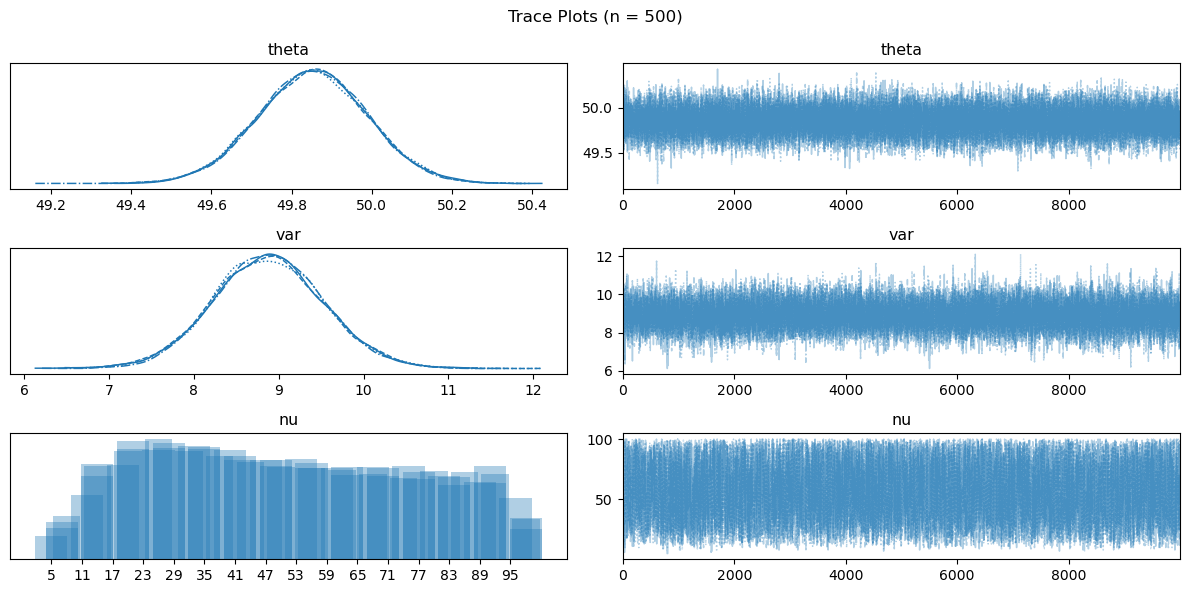


Results for sample size n = 1000:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  49.821   0.092  49.651   49.995      0.000    0.000   38048.0   
var     8.090   0.429   7.261    8.878      0.004    0.003   12864.0   
nu     56.369  24.450  16.000   96.000      0.316    0.224    5735.0   

       ess_tail  r_hat  
theta   29226.0    1.0  
var     14544.0    1.0  
nu       5521.0    1.0  


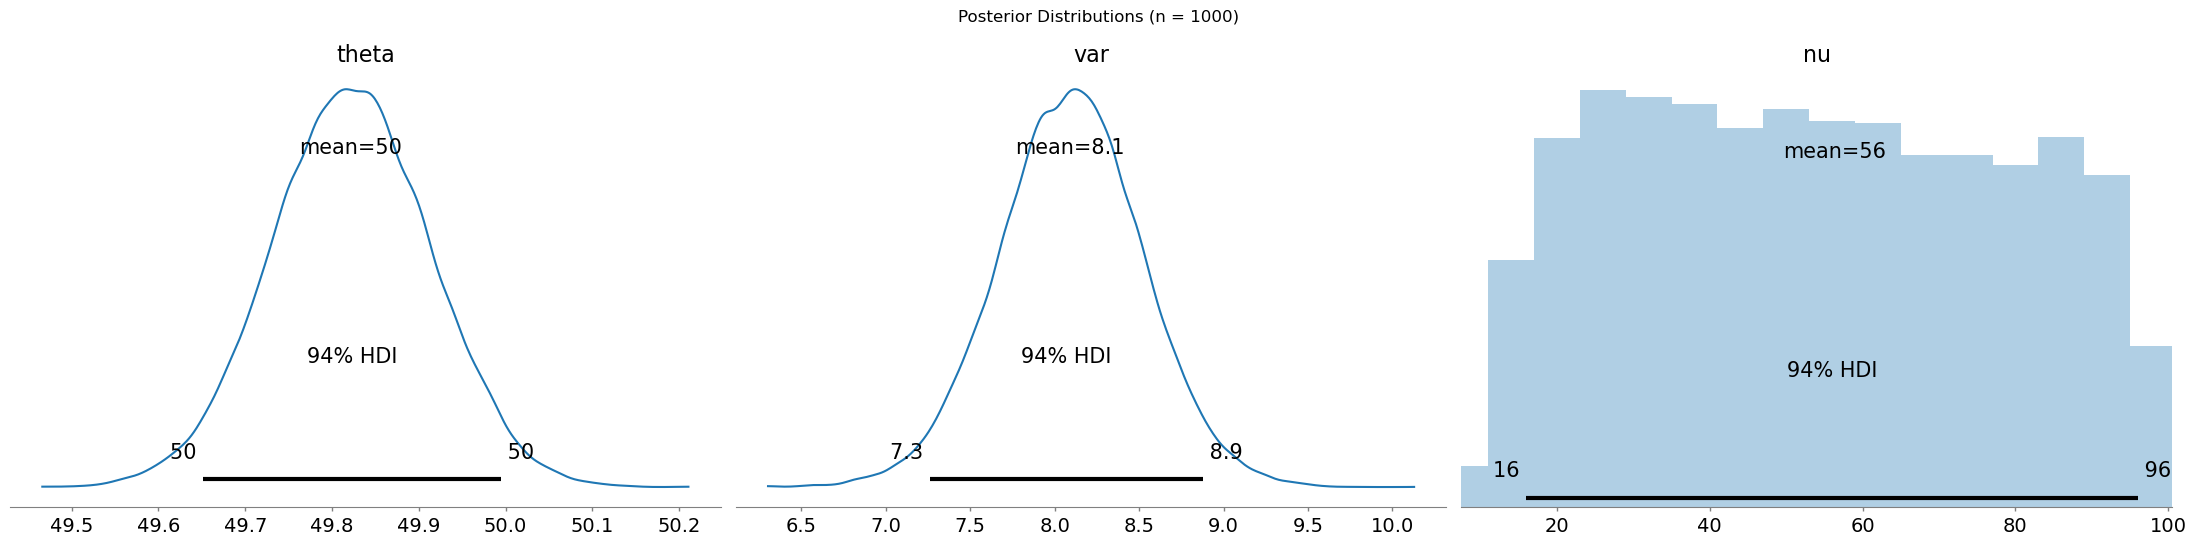

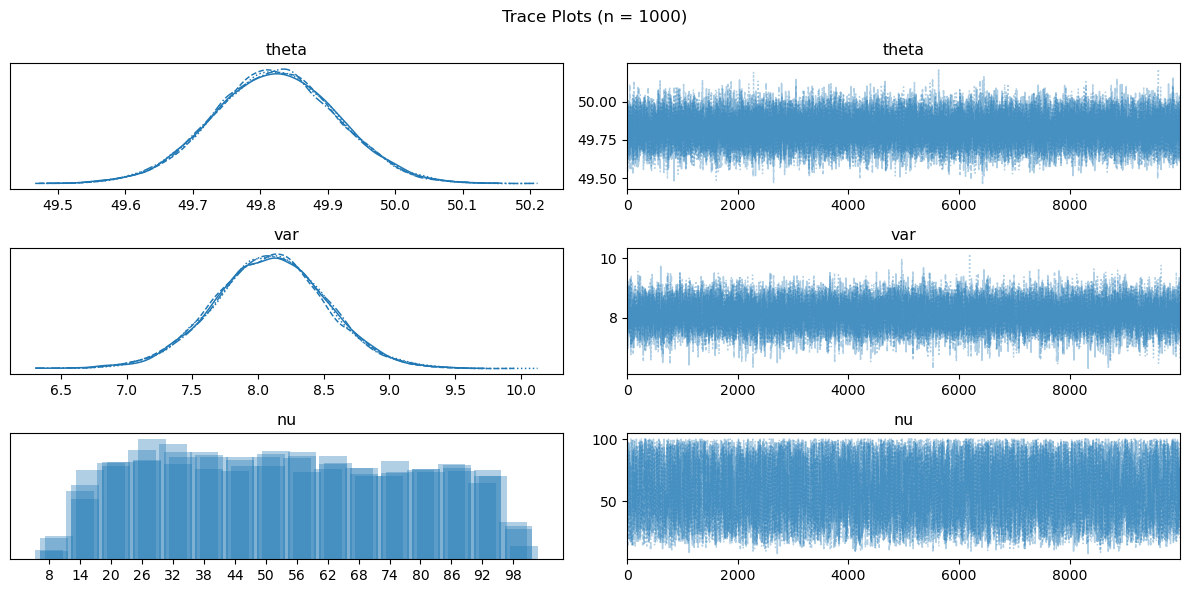


Results for sample size n = 5000:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  49.951   0.043  49.871   50.033      0.000    0.000   35827.0   
var     8.893   0.206   8.497    9.273      0.002    0.001   14989.0   
nu     68.792  19.274  38.000  100.000      0.245    0.173    6252.0   

       ess_tail  r_hat  
theta   28120.0    1.0  
var     17297.0    1.0  
nu       7332.0    1.0  


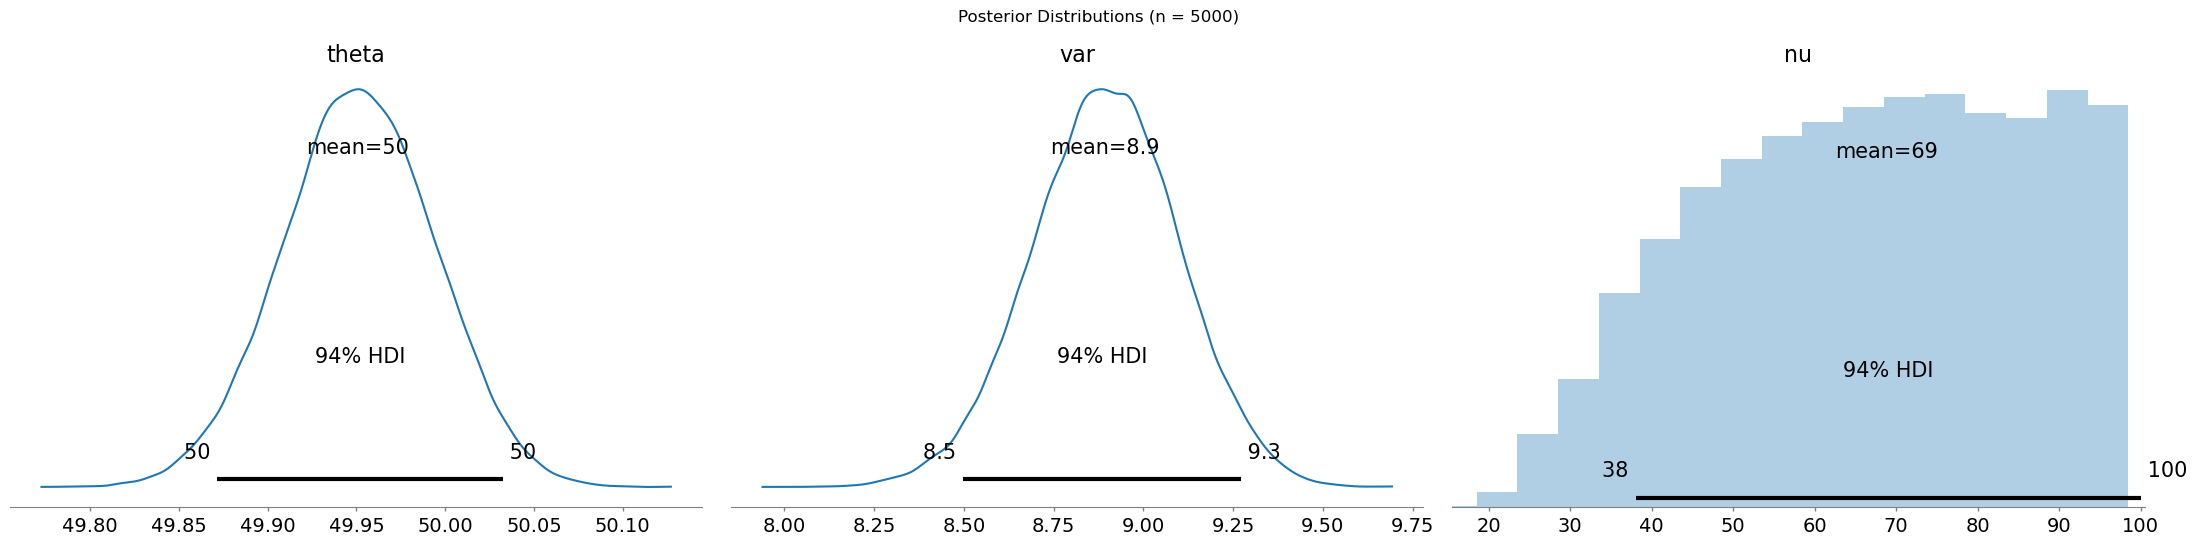

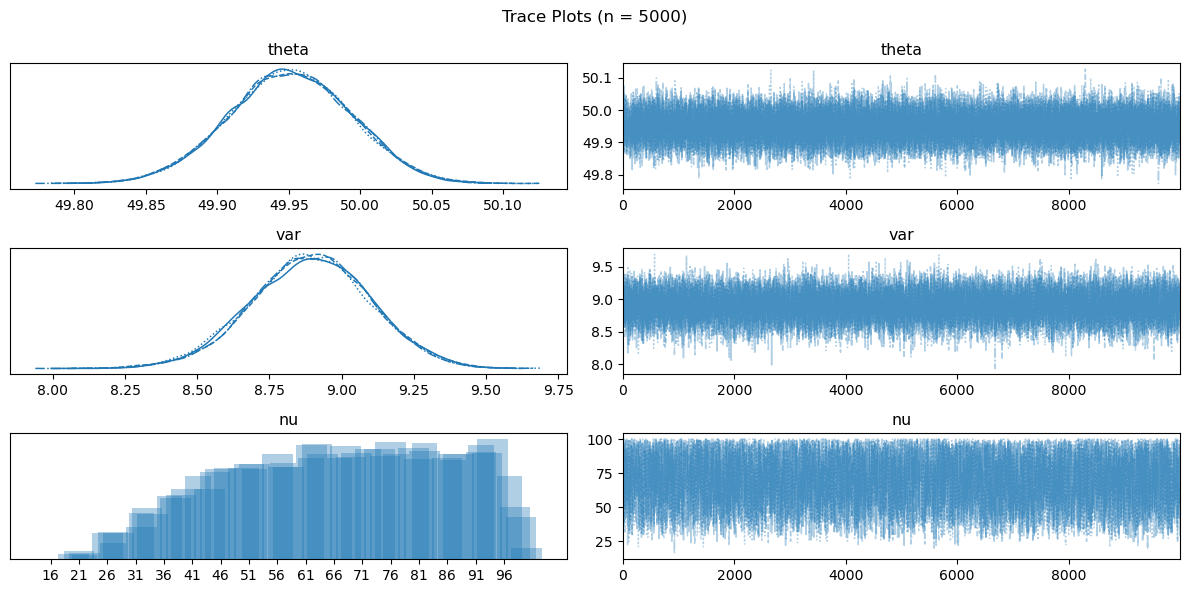


Results for sample size n = 10000:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  50.044   0.030  49.988   50.101      0.000    0.000   39294.0   
var     8.775   0.138   8.518    9.035      0.001    0.001   19559.0   
nu     79.627  14.793  53.000  100.000      0.187    0.132    6203.0   

       ess_tail  r_hat  
theta   28895.0    1.0  
var     20624.0    1.0  
nu       7444.0    1.0  


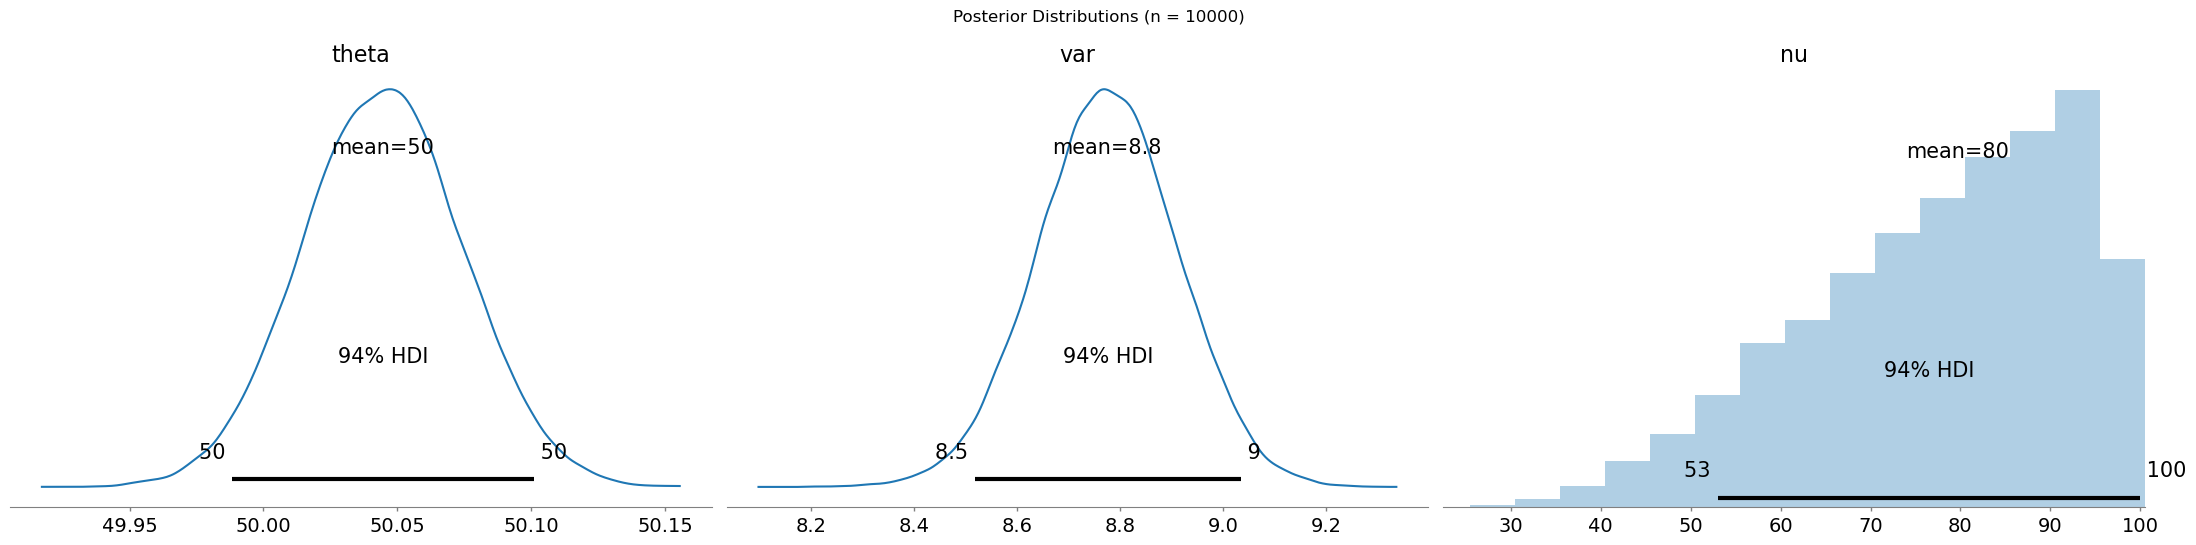

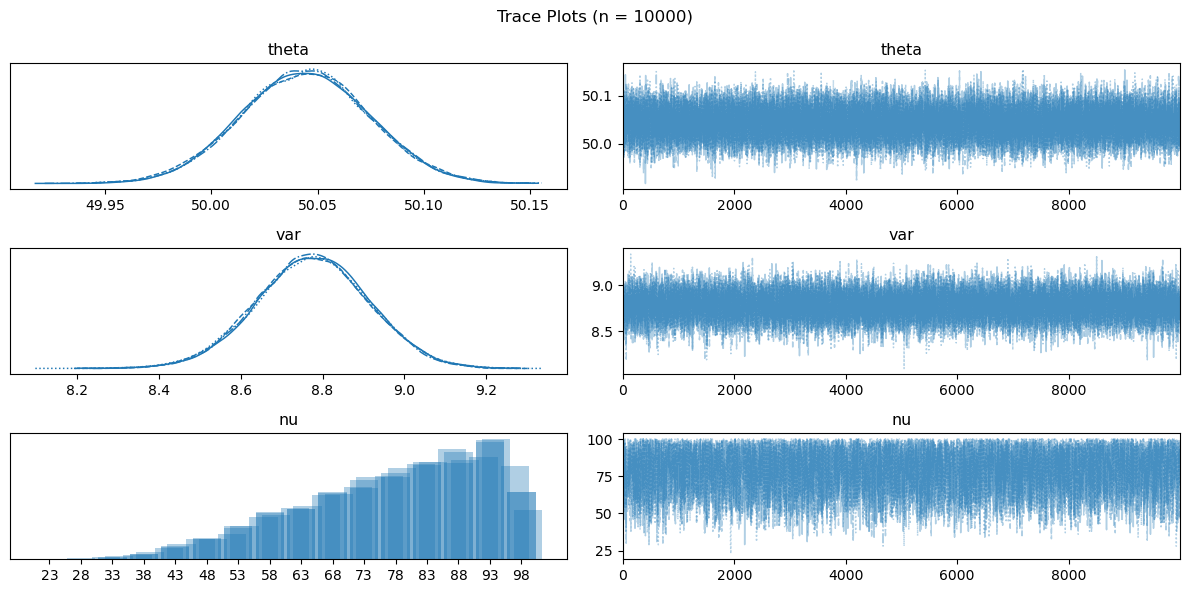

In [6]:
for n in sample_sizes:
    # Summarize results for this sample size
    print(f"\nResults for sample size n = {n}:")
    summary = az.summary(results[f"n={n}"], var_names=["theta", "var", "nu"])
    print(summary)

    # Plot posterior distributions for theta, var, and nu
    az.plot_posterior(results[f"n={n}"], var_names=["theta", "var", "nu"])
    plt.suptitle(f"Posterior Distributions (n = {n})")
    plt.tight_layout()
    plt.show()

    # Plot trace plots to check convergence
    az.plot_trace(results[f"n={n}"], var_names=["theta", "var", "nu"])
    plt.suptitle(f"Trace Plots (n = {n})")
    plt.tight_layout()
    plt.show()

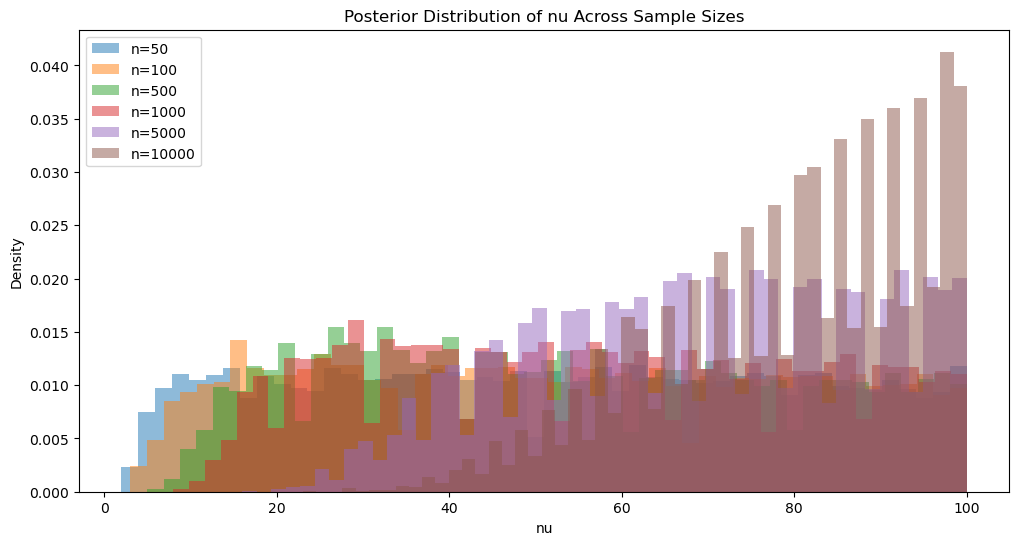


Summary of nu across sample sizes:
n=50: Mean nu = 51.75, Std nu = 27.69
n=100: Mean nu = 52.11, Std nu = 27.16
n=500: Mean nu = 53.59, Std nu = 25.48
n=1000: Mean nu = 56.37, Std nu = 24.45
n=5000: Mean nu = 68.79, Std nu = 19.27
n=10000: Mean nu = 79.63, Std nu = 14.79


In [7]:
# Compare nu across sample sizes
plt.figure(figsize=(12, 6))
for n in sample_sizes:
    nu_samples = results[f"n={n}"]["posterior"]["nu"].values.flatten()
    plt.hist(nu_samples, bins=50, alpha=0.5, label=f"n={n}", density=True)
plt.title("Posterior Distribution of nu Across Sample Sizes")
plt.xlabel("nu")
plt.ylabel("Density")
plt.legend()
plt.show()

# Print mean and standard deviation of nu for each sample size
print("\nSummary of nu across sample sizes:")
for n in sample_sizes:
    nu_samples = results[f"n={n}"]["posterior"]["nu"].values.flatten()
    print(f"n={n}: Mean nu = {np.mean(nu_samples):.2f}, Std nu = {np.std(nu_samples):.2f}")

All chains converged and mixed nicely. The mean of nu seems to get larger as sample size increases, and its standard deviation gets smaller.

# Question 3
---
We use $\alpha = \beta = \nu/2$ in the definition of the gamma distribution to get 

$$p(\tau_i) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}\tau_i^{(\nu/2) - 1}\exp(-(\nu/2)\tau_i)$$

Since the gamma distribution is parametrized by shape rate, the mean is $\alpha/\beta = 1$ and variance is $\alpha/\beta^2 = 2/\nu$. Meanwhile, we're also given

$$p(y_i | \tau_i) = \sqrt{\frac{\tau_i}{2\pi}}\exp\left(-\frac{\tau_iy_i^2}{2}\right)$$

Then, we compute

\begin{align*}
p(y_i) &= \int_0^\infty p(y_i | \tau_i)p(\tau_i) d\tau_i \\
&= \int_0^\infty \sqrt{\frac{\tau_i}{2\pi}}\exp\left(-\frac{\tau_iy_i^2}{2}\right)\frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}\tau_i^{(\nu/2) - 1}\exp(-(\nu/2)\tau_i) d\tau_i \\
&= \int_0^\infty \sqrt{\frac{\tau_i}{2\pi}}\frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}\tau_i^{(\nu/2) - 1}\exp\left(-\frac{\tau_iy_i^2}{2}-(\nu/2)\tau_i\right) d\tau_i
\end{align*}

Note

$$-\frac{\tau_iy_i^2}{2}-(\nu/2)\tau_i = -\tau_i\frac{y_i^2 + \nu}{2}$$

and 

$$\sqrt{\frac{\tau_i}{2\pi}}\frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}\tau_i^{(\nu/2) - 1} = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)\sqrt{2\pi}}\tau_i^{(\nu/2 + 1/2) - 1}$$

Then

$$p(y_i) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)\sqrt{2\pi}}\int_0^\infty \tau_i^{(\nu/2 + 1/2) - 1}\exp\left(-\tau_i\frac{y_i^2 + \nu}{2}\right)$$

The unnormalized Gamma$(\alpha, \beta)$ distribution is $x^{\alpha - 1}\exp(-\beta x)$, so comparing that with our result above gives $\alpha = (\nu + 1)/2$ and $\beta = (y_i^2 + \nu)/2$. Our integral thus becomes the reciprocal of the normalizing constant of the Gamma$(\alpha, \beta)$ distribution, so we get

$$p(y_i) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)\sqrt{2\pi}}\frac{\Gamma((\nu+1)/2)}{((y_i^2 + \nu)/2)^{(\nu+1)/2}}$$

The denominator can be written as 

$$\left(\frac{y_i^2 + \nu}{2}\right)^{(\nu+1)/2} = \left(\frac{\nu}{2}\left(\frac{y_i^2}{\nu} + 1\right)\right)^{(\nu+1)/2} = \left(\frac{\nu}{2}\right)^{(\nu+1)/2}\left(1 + \frac{y_i^2}{\nu}\right)^{(\nu+1)/2}$$

Plugging this in gives

$$p(y_i) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)\sqrt{2\pi}}\frac{\Gamma((\nu+1)/2)}{(\nu/2)^{(\nu+1)/2}(1 + y_i^2/\nu)^{(\nu+1)/2}} = \frac{\Gamma((\nu+1)/2)}{\Gamma(\nu/2)\sqrt{\nu\pi}}\left(1 + \frac{y_i^2}{\nu}\right)^{-(\nu+1)/2}$$

This is the pdf of the t-distribution with mean $0$, scale $1$, and $\nu$ degrees of freedom.

The form 

$$p(y_i) = \int_0^\infty p(y_i | \tau_i)p(\tau_i) d\tau_i$$

mirrors that of the posterior predictive

$$p(y_\text{new}|y_\text{old}) = \int p(y_\text{new} | \theta) p(\theta | y_\text{old}) d\theta$$

where $\theta$ represents model parameters. In the derivation above, $p(\theta | y_\text{old})$ is simply $p(\tau_i)$ beacuse we assumed that the distribution of $\tau_i$ is unaffected by any previous data (otherwise the distribution of $\tau_i$ given in our hw problem would be dependent on $y_j$ in some way for $j < i$). Despite that, the idea of taking parameter uncertainty into consideration is still present. This is different from using a point estimate such as the MAP, because $p(y_i, \tau_\text{MAP})$ ignores uncertainty in $\tau$ which can lead to overly confident predictions. 

Meanwhile, $p(y_\text{new} | \theta)$ is simply $p(y_i | \tau_i)$, where we capture the randomness in the data-generating process for a given $\tau_i$.